In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# TODO: add files from which we import functions
from scripts import (
    load_joined_data,
    split_data,
    cap_outliers,
    remove_seasonality_ia,
    restore_seasonality_ia,
    add_lags,
    evaluate_feature_importance,
    dnn,
    evaluate_baseline,
    mean_absolute_percentage_error
)

from catboost import CatBoostRegressor
from deepforest import CascadeForestRegressor
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor

START = datetime(2021, 4, 1, 9, 30)
END = datetime(2022, 4, 1, 16, 0)
BUCKET = 600  # seconds

COLUMNS = ["VOLUME_fut", "VOLUME_etf", "VOLUME_opt"]
TARGET = "VOLUME_fut_target"

if not ("REMOVE_SEASONALITY" in locals() or "REMOVE_SEASONALITY" in globals()):
    REMOVE_SEASONALITY = True
if not ("PLOT_CHARTS" in locals() or "PLOT_CHARTS" in globals()):
    PLOT_CHARTS = True

/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-25 18:07:35.568309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-25 18:07:35.568334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ts = load_joined_data(common_kwargs=dict(start=START, end=END, bucket=BUCKET))

In [3]:
# load cached data
ts = load_joined_data(
    pd.read_csv('./data/etf_nq.csv', index_col='Time'),
    pd.read_csv('./data/fut_nq.csv', index_col='Time'),
    pd.read_csv('./data/opt_nq.csv', index_col='Time'),
)
ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Preparing Data

In [4]:
# split data into training, validation, and test sets (10% each for val and test)
train_indexes, val_indexes, test_indexes = split_data(ts, val_size = 0.1, test_size = 0.1)

# cap outliers to within 4 standard deviations from the mean
ts = cap_outliers(ts, train_indexes, COLUMNS, std_num=4)

# remove seasonality by normalizing based on the intraday average
if REMOVE_SEASONALITY:
    ts = remove_seasonality_ia(ts, COLUMNS, bins=39, window_days=20)

# TODO: remove line below but apply scaler inverse transform for baseline
df_prep = ts.copy()

# scale data to the range [0, 1]
scaler = MinMaxScaler()

train = df_prep.loc[train_indexes, COLUMNS+["hhmm"]]
val = df_prep.loc[val_indexes, COLUMNS+["hhmm"]]
test = df_prep.loc[test_indexes, COLUMNS+["hhmm"]]

df_prep.loc[train_indexes, COLUMNS+["hhmm"]] = scaler.fit_transform(train)
df_prep.loc[val_indexes, COLUMNS+["hhmm"]] = scaler.transform(val)
df_prep.loc[test_indexes, COLUMNS+["hhmm"]] = scaler.transform(test)

df_prep

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target,VOLUME_fut_agg
0,2021-04-01 09:40:00,NaN,NaN,NaN,0.000000,NaN,NaN
1,2021-04-01 09:50:00,NaN,NaN,NaN,0.015152,NaN,NaN
2,2021-04-01 10:00:00,NaN,NaN,NaN,0.090909,NaN,NaN
3,2021-04-01 10:10:00,NaN,NaN,NaN,0.106061,NaN,NaN
4,2021-04-01 10:20:00,NaN,NaN,NaN,0.121212,NaN,NaN
...,...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,0.299234,0.322628,0.399231,0.878788,-1088.95,9960.95
9847,2022-03-31 15:30:00,0.382469,0.321743,0.297174,0.893939,3112.50,9811.50
9848,2022-03-31 15:40:00,0.436710,0.377578,0.380897,0.909091,5850.40,10731.60
9849,2022-03-31 15:50:00,0.369721,0.425946,0.331986,0.924242,2469.05,11291.95


# Add Lags As Features

In [5]:
df = df_prep[COLUMNS + [TARGET, "hhmm"]].copy()
df, lags_columns = add_lags(
    df, COLUMNS, periods=[1, 2, 3, 4, 38, 39, 78, 195]
)
df = df.dropna()
train_indexes = df.index.intersection(train_indexes)
df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
975,0.417079,0.347085,0.293045,0.322147,0.324096,0.389872,0.335679,0.267483,0.592493,0.405472,0.322109,0.334707,0.427673,0.567808,0.514717,0.388671,0.319410,0.389250,0.297848,0.494169,0.281198,0.445175,0.484076,0.643841
976,0.484750,0.417079,0.347085,0.293045,0.379511,0.324096,0.318159,0.285332,0.698065,0.592493,0.405472,0.322109,0.427382,0.427673,0.502920,0.307297,0.588489,0.319410,0.389250,0.297848,0.249154,0.281198,0.349573,0.402524
977,0.512793,0.484750,0.417079,0.347085,0.324532,0.379511,0.301498,0.321312,0.656628,0.698065,0.592493,0.405472,0.407827,0.427382,0.414253,0.351533,0.606438,0.588489,0.319410,0.389250,0.280517,0.249154,0.323936,0.362951
978,0.291243,0.512793,0.484750,0.417079,0.410223,0.324532,0.473665,0.290855,0.406560,0.656628,0.698065,0.592493,0.421218,0.407827,0.564485,0.317911,0.394602,0.606438,0.588489,0.319410,0.272937,0.280517,0.433665,0.380491
979,0.335728,0.291243,0.512793,0.484750,0.337032,0.410223,0.359556,0.310240,0.473763,0.406560,0.656628,0.698065,0.408971,0.421218,0.414871,0.284335,0.452354,0.394602,0.606438,0.588489,0.306765,0.272937,0.446248,0.280449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.348067,0.268115,0.277756,0.295003,0.426359,0.367592,0.276272,0.246880,0.429821,0.277402,0.300861,0.320182,0.507624,0.462062,0.356503,0.278311,0.430508,0.324241,0.264198,0.271235,0.315066,0.432664,0.308608,0.301425
9847,0.299234,0.348067,0.268115,0.277756,0.371693,0.426359,0.287676,0.305755,0.322628,0.429821,0.277402,0.300861,0.342273,0.507624,0.491972,0.282940,0.399231,0.430508,0.324241,0.264198,0.270838,0.315066,0.266701,0.383216
9848,0.382469,0.299234,0.348067,0.268115,0.343206,0.371693,0.290879,0.258375,0.321743,0.322628,0.429821,0.277402,0.333295,0.342273,0.346352,0.247779,0.297174,0.399231,0.430508,0.324241,0.329119,0.270838,0.244663,0.251107
9849,0.436710,0.382469,0.299234,0.348067,0.269890,0.343206,0.302878,0.230263,0.377578,0.321743,0.322628,0.429821,0.318232,0.333295,0.376007,0.201392,0.380897,0.297174,0.399231,0.430508,0.186554,0.329119,0.264143,0.221001


## Features Importance

Feature Importance: model is not specified, using CatBoostRegressor


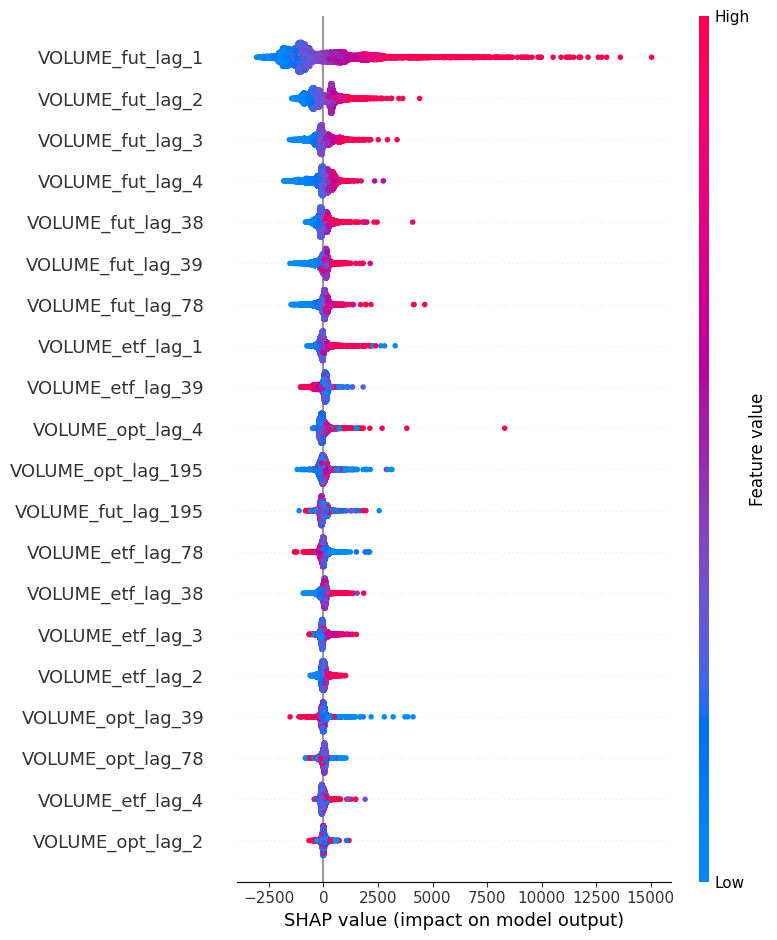

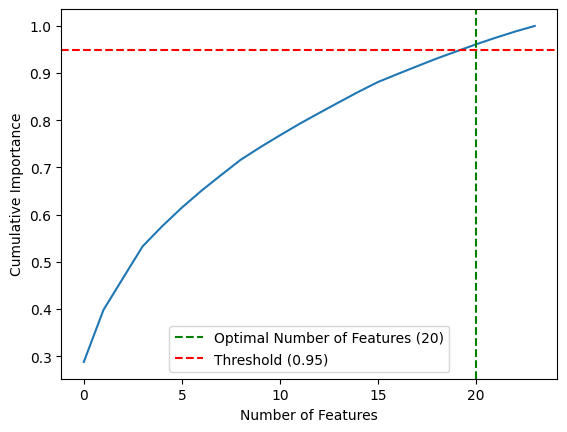

In [6]:
top_features = evaluate_feature_importance(
    df, train_indexes, lags_columns, TARGET, threshold=0.95, plot=PLOT_CHARTS
)

# Training

In [7]:
if not REMOVE_SEASONALITY:
    top_features = list(top_features) + ["hhmm"]
x_train, x_val, x_test = df.loc[train_indexes, top_features], df.loc[val_indexes, top_features], df.loc[test_indexes, top_features]
y_train, y_val, y_test = df.loc[train_indexes, TARGET], df.loc[val_indexes, TARGET], df.loc[test_indexes, TARGET]
metrics = {}

## Baseline Model

In [8]:
metrics_baseline = evaluate_baseline(
    ts,
    test_indexes,
    target_col=TARGET,
    target_agg_col="VOLUME_fut_agg",
    hhmm_col="hhmm",
    remove_seasonality=REMOVE_SEASONALITY,
)

metrics["baseline"] = metrics_baseline
metrics

{'baseline': {'R2': 0.6916495403944667,
  'MAE': 2570.732538071066,
  'MAPE': 0.21190262146108615}}

## Simple models

### Determine models

In [9]:
xgb = XGBRegressor()
cat = CatBoostRegressor()
cfr = CascadeForestRegressor()
dnn = KerasRegressor(
    model=dnn,
    loss='mean_squared_error',
    optimizer='adam',
    # TODO: remove parameters below from here
    hid_layers_num=2,
    neurons_num_layer1=4,
    activation_layer1='relu',
    dropout_layer1=0,
    neurons_num_layer2=4,
    activation_layer2='relu',
    dropout_layer2=0,
    batch_size=32,
    epochs=3,
    verbose=0,
    random_seed=42,
)

### Models parameters

In [10]:
models = {
    'xgboost': {
        'class': xgb, 
        'init_params': {
            'n_estimators': [100, 500], 
            'max_depth': [3, 4], 
            'learning_rate': [0.1], 
            'verbosity': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {'verbose': False}
        },
    'catboost': {
        'class': cat, 
        'init_params': {
            'n_estimators': [100, 500],
            'max_depth': [3, 4],
            'learning_rate': [0.1],
            'verbose': [0],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
        },
    'cascadeforest': {
        'class': cfr,
        'init_params': {
            # 'n_estimators': [3],
            'n_trees': [100, 500],
            'max_depth': [3, 4],
            # 'max_layers': [5],
            'use_predictor': [True],
            'verbose': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {}
    },
    'dnn': {
        'class': dnn,
        'init_params': {
            'hid_layers_num': [2],
            'neurons_num_layer1': [28, 32],
            'activation_layer1': ['relu'],
            'dropout_layer1': [0],
            'neurons_num_layer2': [28, 32],
            'activation_layer2': ['relu'],
            'dropout_layer2': [0],
            'batch_size': [32],
            'epochs': [100],
            'verbose': [0],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
    }
}

### Determine metrics

In [11]:
# TODO: refactor code below
def custom_r2_scorer(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(y_pred, ts)
    else:
        tdf_test = y_pred.join(ts)[['VOLUME_fut_pred', 'VOLUME_fut_target']]
        tdf_test['VOLUME_prediction'] = tdf_test['VOLUME_fut_pred']
        tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_target']
    r2 = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    return r2

def custom_mape_scorer(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(y_pred, ts)
    else:
        tdf_test = y_pred.join(ts)[['VOLUME_fut_pred', 'VOLUME_fut_target']]
        tdf_test['VOLUME_prediction'] = tdf_test['VOLUME_fut_pred']
        tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_target']
    mape = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    return mape

custom_r2_scorer_obj = make_scorer(custom_r2_scorer)
custom_mape_scorer_obj = make_scorer(custom_mape_scorer)

In [12]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# TODO: it needs to develop custom mape and r2 scorers which make inverse transform before calculating metrics
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

### GSCV

In [13]:
cv_metrics = pd.DataFrame()
sklearn_params = dict(
                scoring={
                    'MAE': mae_scorer, 
                    'R2': custom_r2_scorer, 
                    'MAPE': custom_mape_scorer
                },
                cv=10,
                refit='MAE',
                verbose=False,
                n_jobs=10,
            )
best_estimators = {}
for model_name, model_params in models.items():
    print(f"Training {model_name}...")
    gscv = GridSearchCV(
        model_params['class'],
        model_params['init_params'],
        **sklearn_params
    )
    gscv.fit(
        pd.concat([x_train, x_val]),
        np.ravel(pd.concat([y_train, y_val])),
        **model_params['fit_params']
    )
    
    cv_df = pd.DataFrame(gscv.cv_results_)[['params', 
                                            'mean_test_MAE', 'std_test_MAE', 
                                            'mean_test_MAPE', 'std_test_MAPE',
                                            'mean_test_R2', 'std_test_R2']]
    cv_df['model'] = model_name
    cv_metrics = pd.concat([cv_metrics, cv_df], ignore_index=True)
    print("Best mean test score:", gscv.best_score_)
    best_estimators[model_name] = gscv.best_estimator_
cv_metrics

Training catboost...


2023-12-25 18:07:42.796377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-25 18:07:42.796400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-25 18:07:42.838821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-25 18:07:42.838845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-25 18:07:42.861775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Best mean test score: -2084.7287588590443


,params,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model
0,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_seed': 42, 'verbose': 0}",-2084.728759,248.005066,0.203556,0.013405,0.816776,0.031629,catboost
1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'random_seed': 42, 'verbose': 0}",-2121.355267,257.276905,0.207036,0.012330,0.811580,0.033902,catboost
2,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_seed': 42, 'verbose': 0}",-2087.151894,250.123956,0.203619,0.012953,0.816842,0.031454,catboost
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_seed': 42, 'verbose': 0}",-2130.315999,261.468810,0.208067,0.011801,0.810968,0.033035,catboost


### Evaluation

In [14]:
# TODO: refactor below and remove hard-coded values (package it into a function?)
for model_name, estimator in best_estimators.items():
    y_pred = pd.DataFrame(estimator.predict(x_test), index=x_test.index, columns=['VOLUME_fut_pred'])

    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(y_pred, ts)
    else:
        tdf_test = y_pred.join(ts)[['VOLUME_fut_pred', 'VOLUME_fut_target']]
        tdf_test['VOLUME_prediction'] = tdf_test['VOLUME_fut_pred']
        tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_target']
    
    tdf_test.dropna(inplace=True)
    r2 = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    mae = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    mape = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    
    metrics[model_name] = {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }
metrics

{'baseline': {'R2': 0.6916495403944667,
  'MAE': 2570.732538071066,
  'MAPE': 0.21190262146108615},
 'catboost': {'R2': 0.7655673914457107,
  'MAE': 2212.7026699845546,
  'MAPE': 0.1868531159603609}}